## Crop images
Overlay polygons, create a mask, change pixel dimensions and plot

In [4]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.path import Path

from shapely import wkt
import os
import fnmatch
from rasterio.plot import show
import rasterio as rio
from rasterio.windows import Window
import cv2

import geopandas as gpd

from h3.utils.directories import get_xbd_dir
from h3.utils.directories import get_data_dir

from h3.dataprocessing.extract_metadata import extract_metadata
#from h3.dataprocessing.extract_metadata import extract_damage_allfiles_ensemble
from h3.dataprocessing.extract_metadata import filter_files

Get all necessary paths to files and folders

In [8]:
CLASSES_DICT = {
    "no-damage": 0,
    "minor-damage": 1,
    "major-damage": 2,
    "destroyed": 3,
    "un-classified": 4
}

xbd_dir = get_xbd_dir()
data_dir = get_data_dir()
labels_path = "geotiffs.old/hold/labels/"
filepath = os.path.join(xbd_dir, labels_path, "")
fulldirectory_files = [os.path.join(filepath, file)
                       for file in os.listdir(filepath)]

In [10]:
path_save_pre = os.path.join(data_dir, 
                                  "datasets/processed_data/metadata_pickle",
                                  "pre_polygons_damage_old.pkl")

hallo = pd.read_pickle(path_save_pre)

In [11]:
first_column = hallo.iloc[200]
load_image = first_column["image_name"].replace("png", "tif")

json_path = os.path.join(filepath, load_image)
image_path = json_path.replace("labels", "images")

In [12]:
first_column["image_name"]

'hurricane-harvey_00000395_pre_disaster.png'

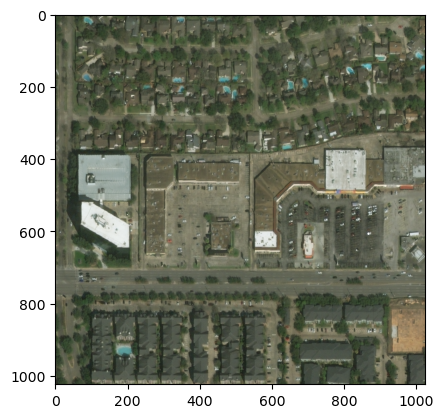

In [13]:
with rio.open(image_path) as img:
    image_array = img.read()
    image_meta = img.profile

    f, ax = plt.subplots()
    ax = rio.plot.show(image_array, ax=ax)  

In [14]:
# get metadata
first_column

point_lnglat           POINT (-95.58012814580206 29.73910938623323)
polygon_lnglat    POLYGON ((-95.58018714672598 29.73919037142823...
point_xy                POINT (252.6810572229474 146.2656677633576)
geometry          POLYGON ((240.8883433750822 126.7687432557578,...
disaster_name                                      hurricane-harvey
image_name               hurricane-harvey_00000395_pre_disaster.png
capture_date                              2017-02-16 17:11:58+00:00
match_num                                                        22
damage_class                                                      0
Name: 200, dtype: object

In [16]:
print(list(CLASSES_DICT.keys())[first_column["damage_class"]])

no-damage


TypeError: no numeric data to plot

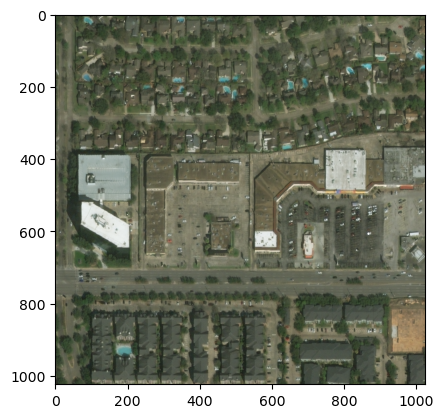

In [17]:
with rio.open(image_path) as img:
    f, ax = plt.subplots()
    ax = rio.plot.show(img.read(), ax=ax)
    ax.ticklabel_format(useOffset=False)
    
    # hallo.iloc[200].plot(ax=ax,column = "damage_class", categorical = True)
    first_column.plot(ax=ax, column = "damage_class", legend = True)

https://carpentries-incubator.github.io/geospatial-python/08-crop-raster-data/index.html
https://stackoverflow.com/questions/50331025/how-to-crop-a-bounding-box-out-of-an-image 

Repurposing masks into bounding boxes!
https://pytorch.org/vision/stable/auto_examples/plot_repurposing_annotations.html#sphx-glr-auto-examples-plot-repurposing-annotations-py

the save bounding box as png:
https://pytorch.org/vision/stable/generated/torchvision.utils.draw_bounding_boxes.html 

In [32]:
def polygon_mask(img, polygon, im_size):
    img = img.read()
    image_size = (im_size, im_size)
    
    empty_mask = np.zeros(image_size, np.uint8)
    extract_coords = lambda row: np.array(row).astype(np.int32)
    poly_coords = [extract_coords(polygon.exterior.coords)]
    image_mask = cv2.fillPoly(empty_mask, poly_coords, 1)
    return image_mask

In [33]:
def mask_to_bb(Y):
    nx, ny = np.nonzero(Y)
    # check if polygon is empty
    if len(nx)==0 or len(ny) == 0:  
        return np.zeros(4, dtype=np.float32)
    top_y= np.min(ny)
    bottom_y = np.max(ny)
    left_x = np.min(nx)
    right_x = np.max(nx)
    return np.array([left_x, top_y, right_x, bottom_y], dtype=np.int64)

In [2]:
import json
json_link = "/Users/Lisanne/Documents/AI4ER/hurricane-harm-herald/data/datasets/xBD_data/geotiffs.old/hold/labels/hurricane-florence_00000511_post_disaster.json"
with open(json_link, 'r') as j:
    json_data = json.loads(j.read())

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [164]:
def crop_images(img, polygon_df, crop_size, im_size):
    polygon_grid = polygon_mask(img, polygon_df, im_size)
    bounding_box = mask_to_bb(polygon_grid)
    x_size, y_size = crop_size, crop_size
    
    # extract bounding box information
    x1 = int(bounding_box[1])
    x2 = int(bounding_box[3]) 
    y1 = int(bounding_box[0])
    y2 = int(bounding_box[2])
    
    x_min = 0
    x_max = img.width - x_size
    y_min = 0
    y_max = img.width - y_size
    
    # find out if house is on the edge and potentially cut off
    # we will not be using incomplete houses
    if x1 == x_min or x2 == x_max or y1 == y_min or y2 == y_max:
        return
    
    if (y2-y1) > y_size or (x2-x1) > x_size:
        # give it an empty array
        print("house is larger than the box!")
        return
    else:
        # find centre point of the bounding box
        x_offset = (x2+x1)//2
        y_offset = (y2+y1)//2
        print(x_offset)
        print(y_offset)
        
    # find out whether the whole environment around house can be imaged
    if (y_offset + y_size/2 > im_size or y_offset - y_size/2 < y_min or 
        x_offset + x_size/2 > im_size or x_offset - x_size/2 < x_min):
        # fill up with Nan
        print("Oh no we have to fill it up")
        print(img)
        return
    else:
        # rasterio Window is a view on a rectangular subset of the raster dataset
        window = Window(x_offset, y_offset, x_size, y_size)
        print(img)
        
        
    # preserve image metadata
    img_bands = img.meta["count"]
    img_crs = img.meta["crs"]
    metadata_profile = img.profile
    metadata_profile.update({
        "height": x_size,
        "width": y_size,
        "count": img_bands,
        "crs": img_crs})
    
    with rio.open("output.tif", "w", **metadata_profile) as src:
        # Read the data from the window and write it to the output raster
        src.write(img.read(window=window))

In [165]:
with rio.open(image_path) as img:
    image_size = 1024
    crop_size = 224
    crop_images(img, first_column["geometry"], crop_size, image_size)   

254
144
<open DatasetReader name='/Users/Lisanne/Documents/AI4ER/hurricane-harm-herald/data/datasets/xBD_data/geotiffs.old/hold/images/hurricane-harvey_00000395_pre_disaster.tif' mode='r'>


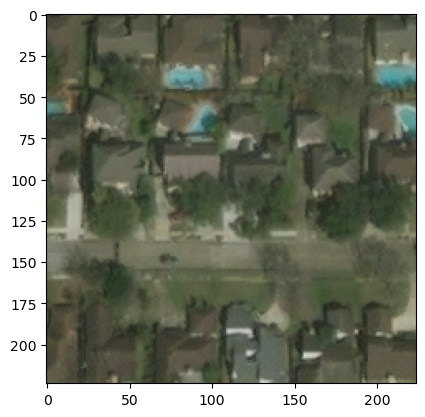

(3, 224, 224)


In [161]:
with rio.open("output.tif") as img2:
    rio.plot.show(img2.read())
    print(img2.read().shape)

Does not look correct, too pixellated. So need help lol

- WE NEED CENTERED
- EDGE case: buffer it with NaN
- Split house -> get rid of it

## Implement edge cases

In [229]:
import cv2
def image_resize(roi, crop_size, pixel_num):
    scale_factor = pixel_num/crop_size
    channels , nx, ny= map(int, roi.shape)
    
    # downscale resolution
    if crop_size > pixel_num:
        new_img = cv2.pyrDown(roi, dstsize=(scale_factor * ny, 2 * nx))
        print(new_img.shape)
    if crop_size == pixel_num:
        return
    # upscale resolution
    else:
        new_img = cv2.pyrUp(roi, dstsize=((scale_factor / ny), (scale_factor / nx)))
        print(new_img.shape)
    return new_img       

In [238]:
import cv2
def image_resize(roi, crop_size, pixel_num):
    width = pixel_num
    height = pixel_num
    
    dim = (width, height)
    new_img = cv2.resize(roi, dim, interpolation = cv2.INTER_AREA) 
    
    return new_img       

In [239]:
def crop_images(img, polygon_df, crop_size, pixel_num, im_size):
    polygon_grid = polygon_mask(img, polygon_df, im_size)
    bounding_box = mask_to_bb(polygon_grid)
    x_size, y_size = crop_size, crop_size
    
    # extract bounding box information
    x1 = int(bounding_box[1])
    x2 = int(bounding_box[3]) 
    y1 = int(bounding_box[0])
    y2 = int(bounding_box[2])
    print("bounding box",bounding_box)
    x_min = 0
    x_max = img.width - x_size
    y_min = 0
    y_max = img.width - y_size
    
    # find out if house is on the edge and potentially cut off
    # we will not be using incomplete houses
    if x1 <= x_min or x2 >= img.width or y1 <= y_min or y2 >= img.width:
        print("House is cut off, so will not be included")
        return
    
    if (y2-y1) > y_size or (x2-x1) > x_size:
        # give it an empty array
        print("House is larger than the box!")
        return
    else:
        # find centre point of the bounding box
        x_offset = (x2+x1)//2
        y_offset = (y2+y1)//2
    
    # Find out dimensions of image cropping around offset
    size_limit = crop_size//2
    
    # find out whether the whole environment around house can be imaged
    if (y_offset + size_limit > y_max or y_offset - size_limit < y_min or 
        x_offset + size_limit > x_max or x_offset - size_limit < x_min):
        print("Oh no we have to fill it up") 
        image_array = img.read()
        shape = (image_array.shape)
        
        # padding around image, add dimensions around offset to all sides
        pad = ((0, 0), (size_limit, size_limit), (size_limit, size_limit))
        padded = np.pad(image_array, pad_width=pad)
        
        padded_x_offset = x_offset + size_limit
        padded_y_offset = y_offset + size_limit

        rio.plot.show(padded)
        roi = padded[:, (padded_y_offset-size_limit) : (padded_y_offset+size_limit), (padded_x_offset-size_limit):(padded_x_offset+size_limit)]

    else:
        # rasterio Window is a view on a rectangular subset of the raster dataset
        #window = Window(x_offset, y_offset, x_size, y_size)

        image_array = img.read()
        roi = image_array[:, (y_offset-size_limit) : (y_offset+size_limit), (x_offset-size_limit):(x_offset+size_limit)]
    
    resized_img = image_resize(roi, crop_size, pixel_num)
        
    # preserve image metadata
    img_bands = img.meta["count"]
    img_crs = img.meta["crs"]
    metadata_profile = img.profile
    metadata_profile.update({
        "height": x_size,
        "width": y_size,
        "count": img_bands,
        "crs": img_crs})
    
    with rio.open("output.tif", "w", **metadata_profile) as src:
        # Read the data from the window and write it to the output raster
        src.write(resized_img)

In [246]:
with rio.open(image_path) as img:
    image_size = 1024
    crop_size = 112
    pixel_num = 224
    crop_images(img, first_column["geometry"], crop_size, pixel_num, image_size) 

bounding box [126 238 163 271]


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Expected sequence length 2, got 3
>  - Can't parse 'dsize'. Expected sequence length 2, got 3


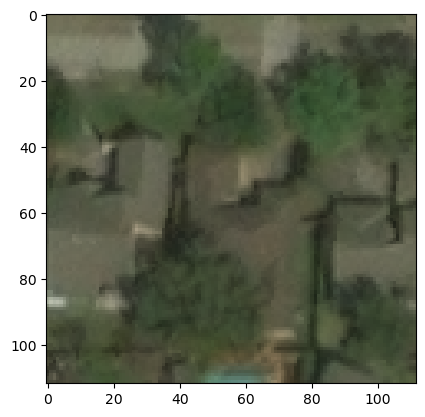

(3, 112, 112)


In [222]:
with rio.open("output.tif") as img2:
   rio.plot.show(img2.read())
   print(img2.read().shape)


## Resize image
Zoom in. Zoom 1x is 224 pixels. Want to maintain pixel size but still want to zoom in 1x or 2x...

In [177]:
img22.shape

(3, 224, 224)

In [181]:
width = img22.shape[1]
height = img22.shape[2]
scaling_factor = 0.5
zoom_width = width*scaling_factor
zoom_height = height*scaling_factor

#crop new image:
with rio.open(image_path) as img:
    crop_images(img, first_column["geometry"], 122, 1024) 

bounding box [126 238 163 271]
nromal y offset 144
nromal x offset 254
size limit is 61


In [176]:
width = img22.shape[1]
height = img22.shape[2]
scaling_factor = 0.5

dsize = (width*scaling_factor, height*scaling_factor)

new_img_array = img22.resize(dsize)
rio.plot.show(new_img_array)

TypeError: 'float' object cannot be interpreted as an integer

# Cells I will need to figure it out 
Not final yet...

In [114]:
y1 = int(bounding_box[0])
x1 = int(bounding_box[1])
y2 = int(bounding_box[2])
x2 = int(bounding_box[3])

In [86]:
roi = image_array[:, y1:y2, x1:x2]

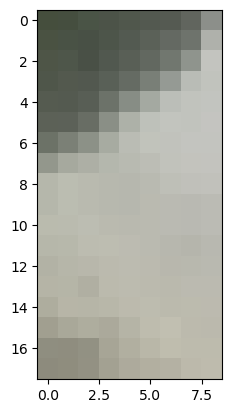

<AxesSubplot:>

In [87]:
import rasterio
from rasterio.plot import show

rio.plot.show(roi)

In [ ]:
def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

In [48]:
mask.shape

(1048576,)

In [31]:
img = cv2.imread(image_path)
print("The tensor shape is (C x H x W:", img.shape)
   

The tensor shape is (C x H x W: (1024, 1024, 3)


In [32]:
with rasterio.open(image_path) as src:

    # The size in pixels of your desired window
    xsize, ysize = 224, 224

    # Generate a random window origin (upper left) that ensures the window 
    # doesn't go outside the image. i.e. origin can only be between 
    # 0 and image width or height less the window width or height
    xmin, xmax = 0, src.width - xsize
    ymin, ymax = 0, src.height - ysize
    xoff, yoff = random.randint(xmin, xmax), random.randint(ymin, ymax)

    # Create a Window and calculate the transform from the source dataset    
    window = Window(xoff, yoff, xsize, ysize)
    transform = src.window_transform(window)

    # Create a new cropped raster to write to
    profile = src.profile
    profile.update({
        'height': xsize,
        'width': ysize,
        'transform': transform})

    with rasterio.open('output.tif', 'w', **profile) as dst:
        # Read the data from the window and write it to the output raster
        dst.write(src.read(window=window))

In [82]:
import rasterio
from rasterio.plot import show

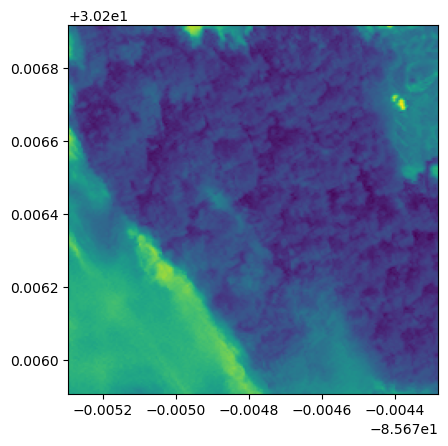

In [34]:
with rasterio.open("output.tif") as src:
    show(src)